In [1]:
!pip install -U "huggingface_hub[cli]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 1.4 MB/s eta 0:00:00


In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `prueba` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate w

In [2]:
!pip install diffusers

In [3]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

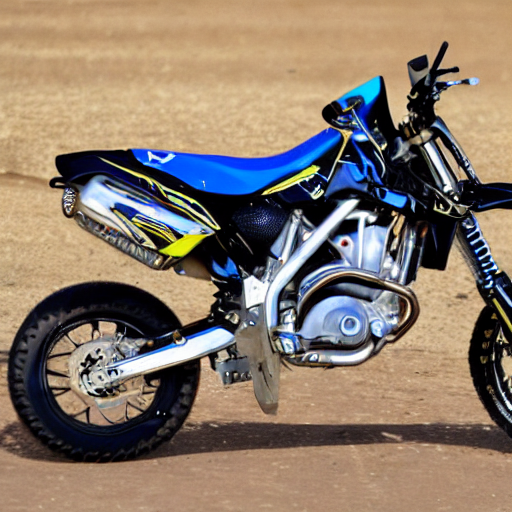

In [16]:
prompt = "moto"
image= pipe(prompt).images[0]
image.save("input.png")
image

In [5]:
!pip install transformers

In [9]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests
import os

def detectar_objetos(ruta_imagen):
    """
    Detecta objetos en una imagen utilizando el modelo YOLOS.

    Args:
        ruta_imagen (str): Ruta local o URL de la imagen a analizar

    Returns:
        list: Lista de detecciones con formato (objeto, confianza, ubicación)
    """
    # Determinar si es una URL o una ruta local y cargar la imagen
    if ruta_imagen.startswith(('http://', 'https://')):
        # Si es URL
        image = Image.open(requests.get(ruta_imagen, stream=True).raw)
    else:
        # Si es ruta local
        if not os.path.exists(ruta_imagen):
            raise FileNotFoundError(f"No se encontró la imagen en: {ruta_imagen}")
        image = Image.open(ruta_imagen)

    # Cargar el modelo y el procesador de imágenes
    model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
    image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

    # Preparar la imagen para el modelo
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # Procesar las predicciones
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(
        outputs,
        threshold=0.9,
        target_sizes=target_sizes
    )[0]

    detecciones = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        deteccion = {
            "objeto": model.config.id2label[label.item()],
            "confianza": round(score.item(), 3),
            "ubicacion": box
        }
        detecciones.append(deteccion)

    return detecciones

In [17]:
# 1. Para una imagen local:
ruta_local = "/content/input.png"  # Ajusta esto a tu ruta local
try:
    resultados = detectar_objetos(ruta_local)
    for r in resultados:
        print(f"Se detectó {r['objeto']} con una confianza de {r['confianza']} en la ubicación {r['ubicacion']}")
except FileNotFoundError as e:
    print(f"Error: {e}")

Se detectó motorcycle con una confianza de 0.997 en la ubicación [4.44, 44.51, 512.75, 471.23]


In [11]:
resultados

[]

In [12]:
# 2. Para una imagen desde URL:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
resultados = detectar_objetos(url)
for r in resultados:
    print(f"Se detectó {r['objeto']} con una confianza de {r['confianza']} en la ubicación {r['ubicacion']}")

Se detectó remote con una confianza de 0.991 en la ubicación [46.48, 72.78, 178.98, 119.3]
Se detectó remote con una confianza de 0.908 en la ubicación [336.48, 79.27, 368.23, 192.36]
Se detectó cat con una confianza de 0.934 en la ubicación [337.18, 18.06, 638.14, 373.09]
Se detectó cat con una confianza de 0.979 en la ubicación [10.93, 53.74, 313.41, 470.67]
Se detectó remote con una confianza de 0.974 en la ubicación [41.63, 72.23, 178.09, 119.99]
